In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from myutils.common import yaml_util
from utils import module_util, net_measure_util

In [2]:
config_file_path = '../config/densenet169.yaml'
config = yaml_util.load_yaml_file(config_file_path)
input_shape = config['input_shape']
model = module_util.get_model(config, 'cpu')

In [3]:
modules = list()
module_util.extract_decomposable_modules(model, torch.rand(input_shape).unsqueeze(0), modules)

(tensor([[ 0.4474, -0.2966, -0.4978,  0.1236,  0.1195,  0.3689,  0.1078,  0.0362,
           0.0659,  0.0942, -0.0342,  0.3214,  0.0775,  0.0267,  0.2052,  0.1833,
           0.2099,  0.0666, -0.1048,  0.3086,  0.6136,  0.0680, -0.0172, -0.4555,
           0.4254,  0.1996, -0.0339, -0.0153, -0.0331, -0.0118,  0.0181,  0.2589,
           0.0675,  0.1402, -0.0280,  0.0896,  0.1548, -0.2492, -0.3150, -0.0819,
           0.0973, -0.4030, -0.0719, -0.5579,  0.1899,  0.0636, -0.2278, -0.2373,
           0.3825, -0.3146,  0.1211,  0.1635, -0.3871,  0.3589,  0.3066,  0.1521,
           0.1296,  0.1648, -0.0528, -0.4650,  0.0074, -0.0155, -0.2295, -0.0690,
           0.1087, -0.1970, -0.4086, -0.0602,  0.1714, -0.0054, -0.3351,  0.1979,
          -0.5695, -0.0497,  0.2330, -0.1127,  0.3915, -0.4283,  0.1363,  0.0005,
          -0.1176,  0.1527,  0.0542,  0.1801,  0.4853,  0.2870,  0.2076, -0.0467,
           0.0841, -0.1646, -0.2380,  0.1542,  0.1339,  0.3836,  0.3691,  0.1041,
          -0.362

In [4]:
for i, module in enumerate(modules):
    print(i, type(module).__name__)

0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 _DenseLayer
5 _DenseLayer
6 _DenseLayer
7 _DenseLayer
8 _DenseLayer
9 _DenseLayer
10 BatchNorm2d
11 ReLU
12 Conv2d
13 AvgPool2d
14 _DenseLayer
15 _DenseLayer
16 _DenseLayer
17 _DenseLayer
18 _DenseLayer
19 _DenseLayer
20 _DenseLayer
21 _DenseLayer
22 _DenseLayer
23 _DenseLayer
24 _DenseLayer
25 _DenseLayer
26 BatchNorm2d
27 ReLU
28 Conv2d
29 AvgPool2d
30 _DenseLayer
31 _DenseLayer
32 _DenseLayer
33 _DenseLayer
34 _DenseLayer
35 _DenseLayer
36 _DenseLayer
37 _DenseLayer
38 _DenseLayer
39 _DenseLayer
40 _DenseLayer
41 _DenseLayer
42 _DenseLayer
43 _DenseLayer
44 _DenseLayer
45 _DenseLayer
46 _DenseLayer
47 _DenseLayer
48 _DenseLayer
49 _DenseLayer
50 _DenseLayer
51 _DenseLayer
52 _DenseLayer
53 _DenseLayer
54 _DenseLayer
55 _DenseLayer
56 _DenseLayer
57 _DenseLayer
58 _DenseLayer
59 _DenseLayer
60 _DenseLayer
61 _DenseLayer
62 BatchNorm2d
63 ReLU
64 Conv2d
65 AvgPool2d
66 _DenseLayer
67 _DenseLayer
68 _DenseLayer
69 _DenseLayer
70 _DenseLayer
7

In [5]:
def find_bottleneck_layers(x, start_idx, modules):
    bottleneck_list = list()
    org_size = np.prod(x.size())
    for i in range(start_idx, len(modules)):
        teacher_model = nn.Sequential(*modules[start_idx:i])
        z = teacher_model(x)
        rate = np.prod(z.size()) / org_size
        if rate < 1.0:
            print('{}\t{}\t{:.4f}\t{}'.format(i, type(modules[i]).__name__, rate, z.size()))

In [6]:
x = torch.ones(1, *input_shape)
start_idx = 0
end_idx = 14
teacher_model = nn.Sequential(*modules[start_idx:end_idx])
z = teacher_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [7]:
student_model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
)
z = student_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [8]:
find_bottleneck_layers(x, start_idx, modules)

14	_DenseLayer	0.6667	torch.Size([1, 128, 28, 28])
15	_DenseLayer	0.8333	torch.Size([1, 160, 28, 28])
30	_DenseLayer	0.3333	torch.Size([1, 256, 14, 14])
31	_DenseLayer	0.3750	torch.Size([1, 288, 14, 14])
32	_DenseLayer	0.4167	torch.Size([1, 320, 14, 14])
33	_DenseLayer	0.4583	torch.Size([1, 352, 14, 14])
34	_DenseLayer	0.5000	torch.Size([1, 384, 14, 14])
35	_DenseLayer	0.5417	torch.Size([1, 416, 14, 14])
36	_DenseLayer	0.5833	torch.Size([1, 448, 14, 14])
37	_DenseLayer	0.6250	torch.Size([1, 480, 14, 14])
38	_DenseLayer	0.6667	torch.Size([1, 512, 14, 14])
39	_DenseLayer	0.7083	torch.Size([1, 544, 14, 14])
40	_DenseLayer	0.7500	torch.Size([1, 576, 14, 14])
41	_DenseLayer	0.7917	torch.Size([1, 608, 14, 14])
42	_DenseLayer	0.8333	torch.Size([1, 640, 14, 14])
43	_DenseLayer	0.8750	torch.Size([1, 672, 14, 14])
44	_DenseLayer	0.9167	torch.Size([1, 704, 14, 14])
45	_DenseLayer	0.9583	torch.Size([1, 736, 14, 14])
65	AvgPool2d	0.8333	torch.Size([1, 640, 14, 14])
66	_DenseLayer	0.2083	torch.Size(

Number of Operations: 3399.00887M


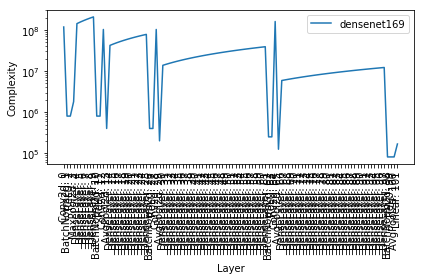

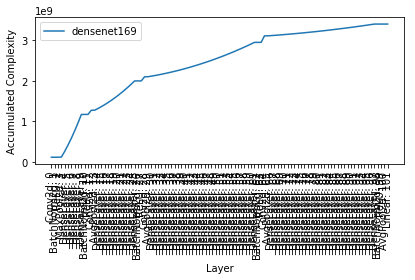

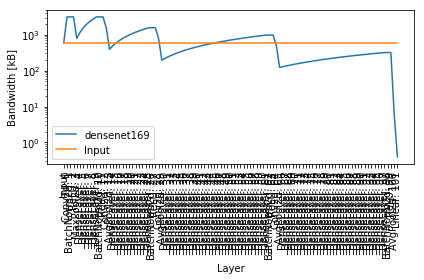

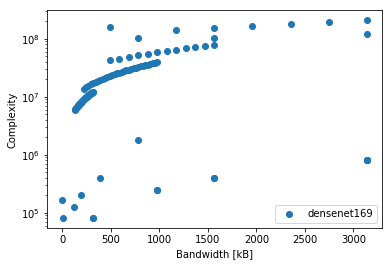

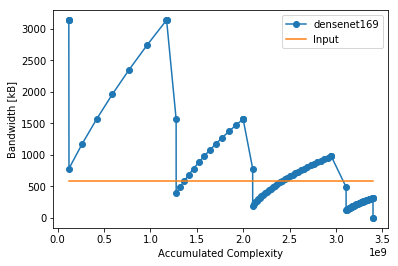

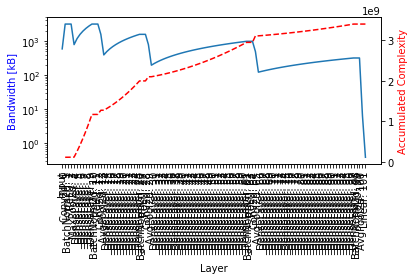

In [9]:
op_count_list, bandwidths, accum_complexities = net_measure_util.compute_model_complexity_and_bandwidth(model, config['model']['type'], input_shape, scaled=False)

Number of Operations: 1276.87885M


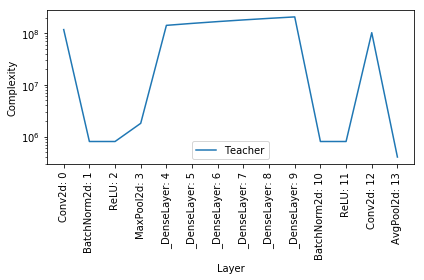

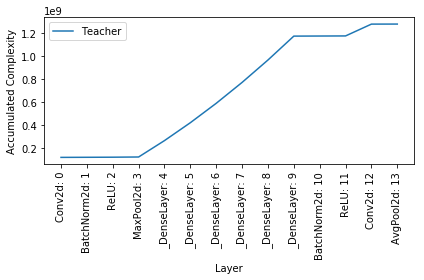

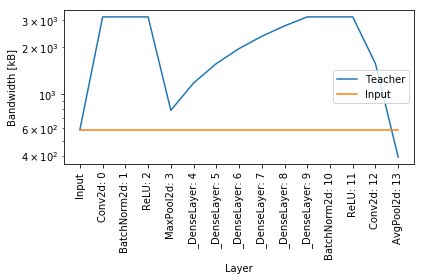

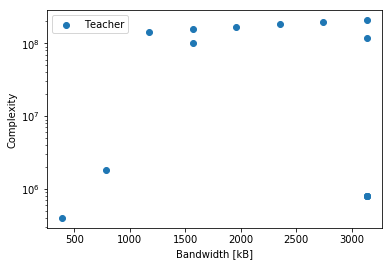

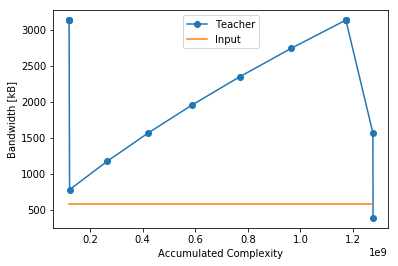

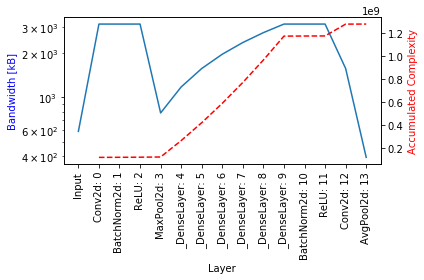

In [10]:
_ = net_measure_util.compute_model_complexity_and_bandwidth(teacher_model, 'Teacher', input_shape, scaled=False)

Number of Operations: 221.35194M


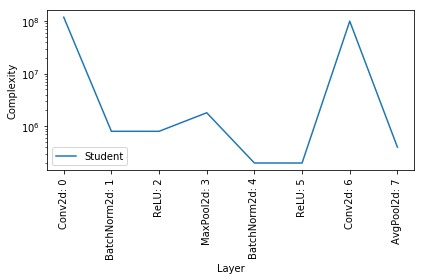

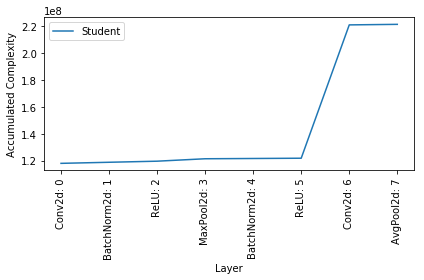

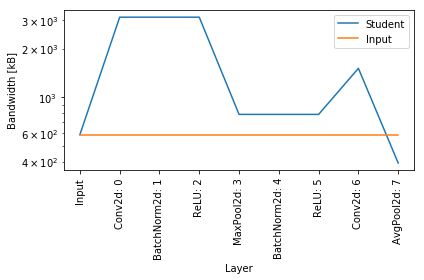

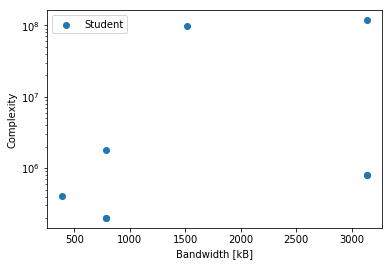

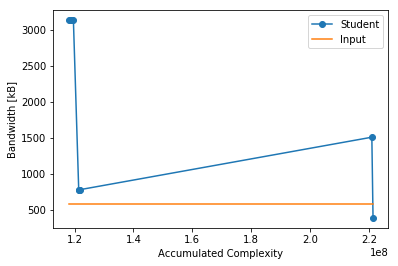

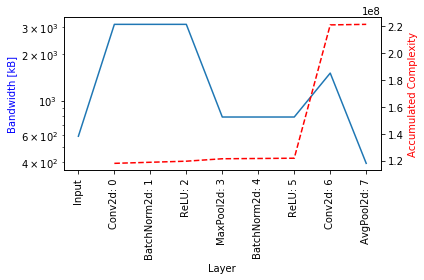

In [11]:
_ = net_measure_util.compute_model_complexity_and_bandwidth(student_model, 'Student', input_shape, scaled=False)

In [12]:
def plot_multiple_models(models, model_types):
    op_counts_list = list()
    bandwidths_list = list()
    accum_complexities_list = list()
    model_type_list = list()
    for model, model_type in zip(models, model_types):
        op_counts, bandwidths, accum_complexities = net_measure_util.compute_model_complexity_and_bandwidth(model, model_types, input_shape, scaled=False, plot=False)
        op_counts_list.append(op_counts)
        bandwidths_list.append(bandwidths)
        accum_complexities_list.append(accum_complexities)
        model_type_list.append(model_type)

    net_measure_util.plot_model_complexities(op_counts_list, model_type_list)
    net_measure_util.plot_accumulated_model_complexities(accum_complexities_list, model_type_list)
    net_measure_util.plot_model_bandwidths(bandwidths_list, False, model_type_list)

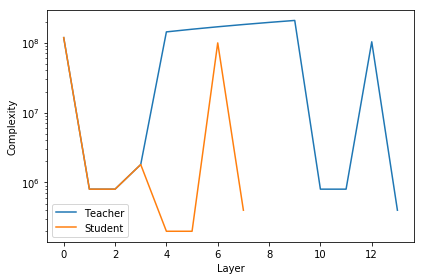

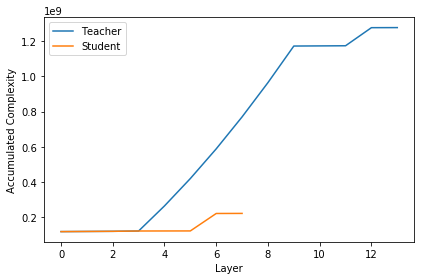

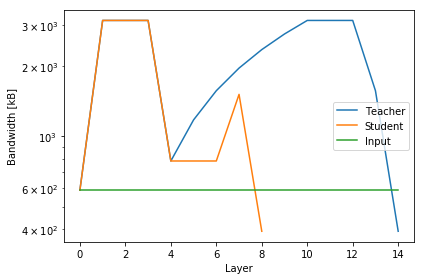

In [13]:
models = [teacher_model, student_model]
model_types = ['Teacher', 'Student']
plot_multiple_models(models, model_types)